In [78]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import FastICA
from scipy.signal import find_peaks

from scipy.signal import find_peaks, welch
from scipy.stats import pearsonr


In [79]:
# Root directory of your dataset
base_dir = './'  # Adjust if needed
output_dir = 'combined_signals'  # Save mixed signals here

os.makedirs(output_dir, exist_ok=True)

In [80]:
# Subdirectory and levels
subdirectory = [f"sub{str(i).zfill(2)}" for i in range(1, 11)]
levels = [f"l{i}" for i in range(1, 6)]

print (subdirectory)
print (levels)

['sub01', 'sub02', 'sub03', 'sub04', 'sub05', 'sub06', 'sub07', 'sub08', 'sub09', 'sub10']
['l1', 'l2', 'l3', 'l4', 'l5']


Step 1 - Combine fecg + mecg + noise 1 + noise 2 

In [81]:
# Iterate through subdirectory and levels
for sub in subdirectory:
    for level in levels:
        prefix = f"{sub}_snr00dB_{level}_c0"
        print(f"Processing: {prefix}")

        sub_folder = os.path.join(base_dir, sub, level)

        try:
            # Read the signals
            fecg = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_fecg1"))
            mecg = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_mecg"))
            noise1 = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_noise1"))
            noise2 = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_noise2"))

            # Extract the signals (first column of each)
            f_ecg = fecg.p_signal[:, 0]
            m_ecg = mecg.p_signal[:, 0]
            n1 = noise1.p_signal[:, 0]
            n2 = noise2.p_signal[:, 0]

            # Ensure they all have the same length
            min_len = min(len(f_ecg), len(m_ecg), len(n1), len(n2))
            f_ecg = f_ecg[:min_len]
            m_ecg = m_ecg[:min_len]
            n1 = n1[:min_len]
            n2 = n2[:min_len]

            # Stack the signals together as a multi-channel signal (4 channels)
            multi_channel_signal = np.stack([f_ecg, m_ecg, n1, n2], axis=1)  # Shape: (samples, 4)

            # Save this multi-channel signal
            record_name = f"{sub}_{level}_c0_combined"

            # Save the combined signals as a WFDB record (4 channels)
            wfdb.wrsamp(
                record_name=record_name,
                fs=fecg.fs,
                units=['mV'] * 4,  # Units for each of the 4 signals
                sig_name=['fecg', 'mecg', 'noise1', 'noise2'],
                p_signal=multi_channel_signal
            )

            # Move the generated .hea and .dat to the combined_signals directory
            os.makedirs(output_dir, exist_ok=True)
            for ext in ['hea', 'dat']:
                os.replace(
                    f"{record_name}.{ext}",
                    os.path.join(output_dir, f"{record_name}.{ext}")
                )

            print(f"Saved combined signal to {record_name}.hea / .dat")

        except Exception as e:
            print(f"Error processing {prefix}: {e}")

Processing: sub01_snr00dB_l1_c0
Saved combined signal to sub01_l1_c0_combined.hea / .dat
Processing: sub01_snr00dB_l2_c0
Saved combined signal to sub01_l2_c0_combined.hea / .dat
Processing: sub01_snr00dB_l3_c0
Saved combined signal to sub01_l3_c0_combined.hea / .dat
Processing: sub01_snr00dB_l4_c0
Saved combined signal to sub01_l4_c0_combined.hea / .dat
Processing: sub01_snr00dB_l5_c0
Saved combined signal to sub01_l5_c0_combined.hea / .dat
Processing: sub02_snr00dB_l1_c0
Saved combined signal to sub02_l1_c0_combined.hea / .dat
Processing: sub02_snr00dB_l2_c0
Saved combined signal to sub02_l2_c0_combined.hea / .dat
Processing: sub02_snr00dB_l3_c0
Saved combined signal to sub02_l3_c0_combined.hea / .dat
Processing: sub02_snr00dB_l4_c0
Saved combined signal to sub02_l4_c0_combined.hea / .dat
Processing: sub02_snr00dB_l5_c0
Saved combined signal to sub02_l5_c0_combined.hea / .dat
Processing: sub03_snr00dB_l1_c0
Saved combined signal to sub03_l1_c0_combined.hea / .dat
Processing: sub03_snr

Step 2: Plot combined signal and separated signals 

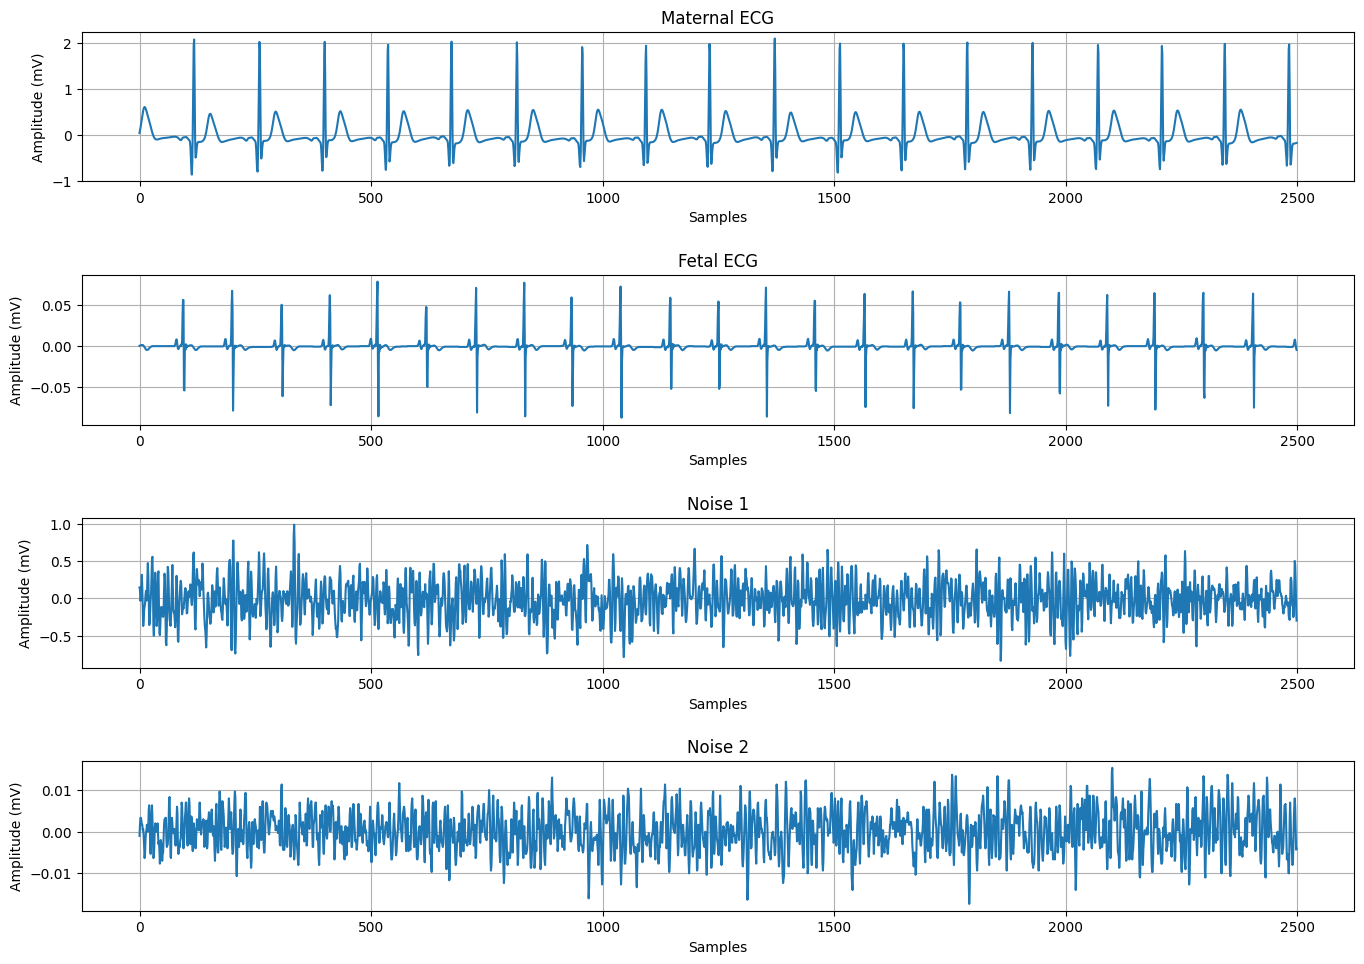

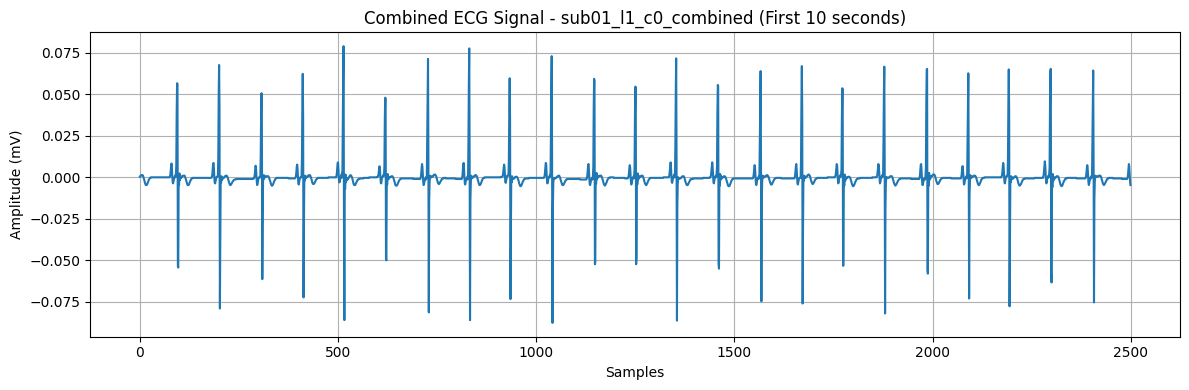

In [82]:
import os
import wfdb
import numpy as np
import matplotlib.pyplot as plt

# Setup
record_name = 'sub01_l1_c0_combined'  # Change as needed
record_path = os.path.join('combined_signals', record_name)

# Load combined signal
record = wfdb.rdrecord(record_path)
combined_signal = record.p_signal[:, 0]
fs = record.fs
seconds = 10
samples_to_plot = int(seconds * fs)

# Load original individual signals (same base name, but from original folders)
subject = "sub01"
level = "l1"
base_dir = "./"
prefix = f"{subject}_snr00dB_{level}_c0"
sub_folder = os.path.join(base_dir, subject, level)

# Read components
fetal = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_fecg1"))
maternal = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_mecg"))
noise1 = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_noise1"))
noise2 = wfdb.rdrecord(os.path.join(sub_folder, f"{prefix}_noise2"))

# Extract and trim
f_ecg = fetal.p_signal[:, 0][:samples_to_plot]
m_ecg = maternal.p_signal[:, 0][:samples_to_plot]
n1 = noise1.p_signal[:, 0][:samples_to_plot]
n2 = noise2.p_signal[:, 0][:samples_to_plot]
combined_signal = combined_signal[:samples_to_plot]

# Plot components + combined
labels = ['Maternal ECG', 'Fetal ECG', 'Noise 1', 'Noise 2']
signals = [m_ecg, f_ecg, n1, n2]

plt.figure(figsize=(14, 12))
for i, sig in enumerate(signals):
    plt.subplot(5, 1, i+1)
    plt.plot(sig)
    plt.title(labels[i])
    plt.xlabel("Samples")
    plt.ylabel("Amplitude (mV)")
    plt.grid()


plt.tight_layout(pad=2)
plt.show()

plt.figure(figsize=(12, 4))
plt.plot(combined_signal[:int(fs*seconds)])
plt.title(f"Combined ECG Signal - {record_name} (First {seconds} seconds)")
plt.xlabel("Samples")
plt.ylabel("Amplitude (mV)")
plt.grid()
plt.tight_layout()
plt.show()


Step 3: Load the combined signal (4 channels signal) and apply FastICA for Blind Source Separation

In [ ]:
# Step 3.1: Load the combined multi-channel signal
# Record name of the combined signal
record_name = 'sub01_l1_c0_combined'  # Change to another record name as needed
record_path = os.path.join('combined_signals', record_name)

# Load the multi-channel signal from the .dat file
record = wfdb.rdrecord(record_path)
multi_channel_signal = record.p_signal  # This is now a matrix of shape (samples, 4)
print (len(multi_channel_signal))

# Sampling frequency
fs = record.fs

75000


In [ ]:
# Step 3.2: Apply ICA for Blind Source Separation
# Initialize the FastICA model (let's separate into 4 components)
ica = FastICA(n_components=4, random_state=0)

# Fit and transform the mixed signal to get the estimated components
separated_signals = ica.fit_transform(multi_channel_signal)  # Shape: (samples, 4)

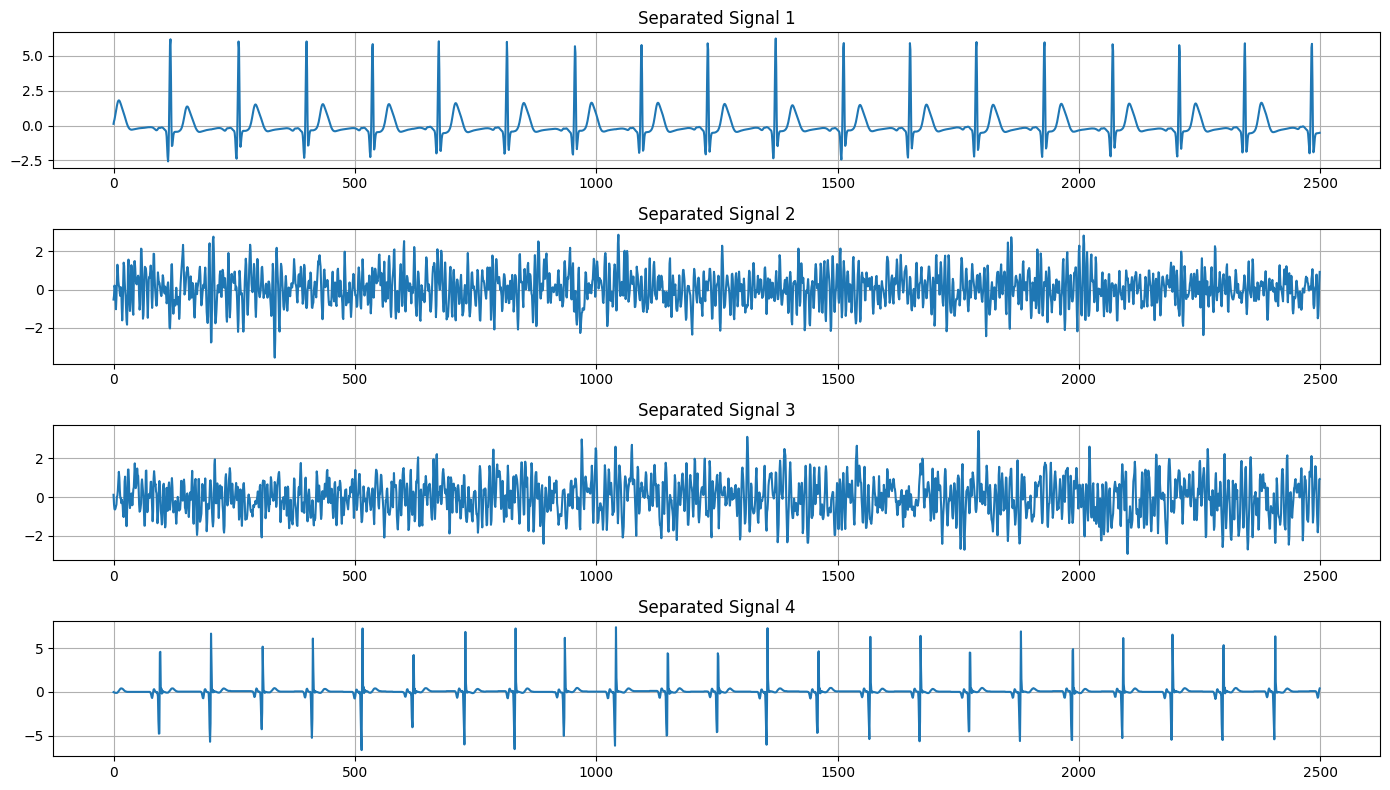

In [ ]:
# Step 3.3 : Plot the results
# Each column of separated_signals is a separated source
labels = ['Separated Signal 1', 'Separated Signal 2', 'Separated Signal 3', 'Separated Signal 4']

plt.figure(figsize=(14, 8))

for i in range(4):
    plt.subplot(4, 1, i+1)
    plt.plot(separated_signals[:record.fs*10, i])  # Plot the first 10 seconds (or adjust as needed)
    plt.title(labels[i])
    plt.grid()

plt.tight_layout()
plt.show()

Step 4: Evaluation of Separation


--- Ground Truth Heart Rates from .qrs ---
True Fetal HR:    143.0 bpm
True Maternal HR: 107.8 bpm

--- ICA Component Heart Rates (using find_peaks) ---
Component 1: Estimated HR = 107.8 bpm
Component 2: Estimated HR = 112.6 bpm
Component 3: Estimated HR = 111.7 bpm
Component 4: Estimated HR = 142.2 bpm


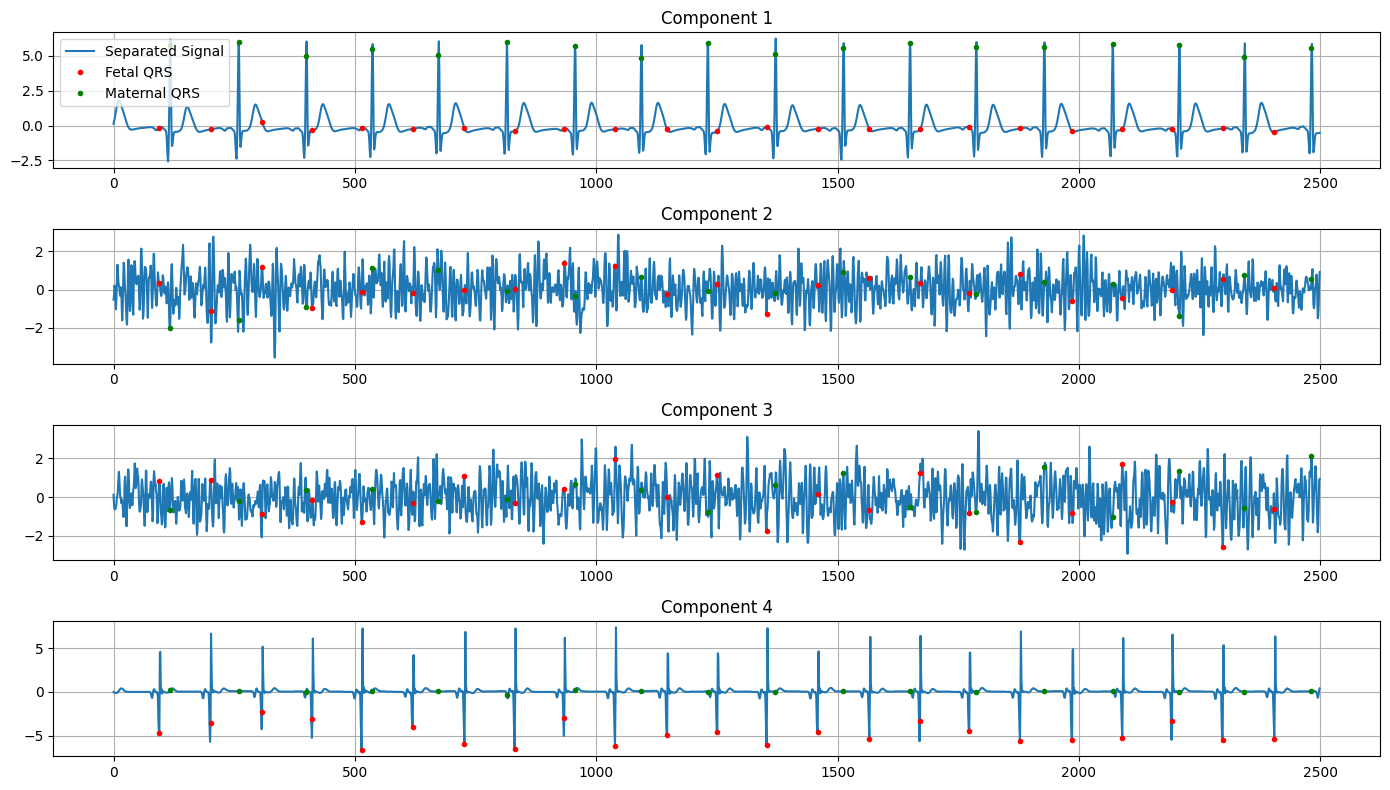

In [ ]:
#Step 4.1: Heart Rate Estimation and comparison against ground truth .qrs annotations

# --- Load .qrs annotations for fetal and maternal ECGs ---
fecg_ann = wfdb.rdann(os.path.join(sub_folder, f"{prefix}_fecg1"), 'qrs')
mecg_ann = wfdb.rdann(os.path.join(sub_folder, f"{prefix}_mecg"), 'qrs')

fecg_rpeaks = fecg_ann.sample
mecg_rpeaks = mecg_ann.sample

def compute_hr(peaks, fs):
    rr_intervals = np.diff(peaks) / fs
    return 60 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0

true_fecg_hr = compute_hr(fecg_rpeaks, fs)
true_mecg_hr = compute_hr(mecg_rpeaks, fs)

print("\n--- Ground Truth Heart Rates from .qrs ---")
print(f"True Fetal HR:    {true_fecg_hr:.1f} bpm")
print(f"True Maternal HR: {true_mecg_hr:.1f} bpm")

# --- Estimate HR for each ICA-separated component ---
print("\n--- ICA Component Heart Rates (using find_peaks) ---")
ica_hr = []
for i in range(4):
    signal = separated_signals[:, i]
    peaks, _ = find_peaks(signal, distance=fs*0.4)
    rr_intervals = np.diff(peaks) / fs
    hr = 60 / np.mean(rr_intervals) if len(rr_intervals) > 0 else 0
    ica_hr.append(hr)
    print(f"Component {i+1}: Estimated HR = {hr:.1f} bpm")

# --- Optional: Visualize ICA components + known peaks ---
plt.figure(figsize=(14, 8))
for i in range(4):
    signal = separated_signals[:, i]
    plt.subplot(4, 1, i+1)
    plt.plot(signal[:fs*10], label='Separated Signal')
    plt.plot(fecg_rpeaks[fecg_rpeaks < fs*10], signal[fecg_rpeaks[fecg_rpeaks < fs*10]], 'ro', label='Fetal QRS', markersize=3)
    plt.plot(mecg_rpeaks[mecg_rpeaks < fs*10], signal[mecg_rpeaks[mecg_rpeaks < fs*10]], 'go', label='Maternal QRS', markersize=3)
    plt.title(f"Component {i+1}")
    if i == 0:
        plt.legend()
    plt.grid()
plt.tight_layout()
plt.show()


In [ ]:
# Step 4.2: Correlation with ground truth signals 
from scipy.stats import pearsonr

originals = [m_ecg, f_ecg]
labels = ['Maternal ECG', 'Fetal ECG']

print("\n--- Correlation with Ground Truth ---")
for i in range(4):
    sep = separated_signals[:, i][:len(m_ecg)]
    print(f"\nComponent {i+1}:")
    for j, orig in enumerate(originals):
        r, _ = pearsonr(sep, orig)
        print(f"   Correlation with {labels[j]}: r = {r:.3f}")



--- Correlation with Ground Truth ---

Component 1:
   Correlation with Maternal ECG: r = 1.000
   Correlation with Fetal ECG: r = -0.007

Component 2:
   Correlation with Maternal ECG: r = 0.013
   Correlation with Fetal ECG: r = 0.002

Component 3:
   Correlation with Maternal ECG: r = 0.042
   Correlation with Fetal ECG: r = -0.007

Component 4:
   Correlation with Maternal ECG: r = 0.007
   Correlation with Fetal ECG: r = -1.000
